In [8]:
from DataPreparation import *
from tqdm import tqdm

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math

datasets = ['CheXpert', 'ChestX-ray8', 'Padchest', 'VinDr-CXR', 'MIMIC-CXR-JPG']
img_dir = 'Datasets/Chestxray'
output_dir = 'Datasets/Chestxray'

### Funciones

In [9]:
def read_latents(file_path):
    all_sigmas = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            sigmas = np.sqrt(np.array(parts[1:], dtype=np.float32)) # Variance is stored, take sqrt to get std
            all_sigmas.append(sigmas)
            
    return np.array(all_sigmas)

def find_uncertainty(input_dir, output_dir, reduce=False):
    img_files = list(pathlib.Path(input_dir).rglob("*")) 
    img_files = [f.relative_to(input_dir) for f in img_files if f.is_file()]
    sigma_avg = []

    for file in img_files:
        df, _ = load_image_and_samples(input_dir, output_dir, file)
        node_groups = df.groupby('Node')
        stds = node_groups[['X', 'Y']].std()
        sigma = (stds['X'] + stds['Y']) / 2
        
        if reduce:
            sigma_avg.append(sigma.values.mean())
        else:
            sigma_avg.append(sigma.values)

    return np.array(sigma_avg).flatten()

In [10]:
def plot_kde_comparison_grid(
    id_skip, ood_skip, id_noskip, ood_noskip, datasets, 
    clip_skip=(0, 0.2), clip_noskip=(0, 0.5),
    suptitle="", n_cols=5, height_per_row=7
):
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, height_per_row * n_rows))
    axes = axes.reshape(n_rows, n_cols)

    for i, dataset in enumerate(datasets):
        col = i % n_cols

        # Handle flexible clip values
        clip_skip_val = clip_skip[dataset] if isinstance(clip_skip, dict) else clip_skip
        clip_noskip_val = clip_noskip[dataset] if isinstance(clip_noskip, dict) else clip_noskip

        # --- Skip row (top) ---
        ax_skip = axes[0, col]
        sns.kdeplot(ood_skip[dataset], fill=True, color="red", label="OOD", ax=ax_skip, alpha=0.5, clip=clip_skip_val)
        sns.kdeplot(id_skip[dataset], fill=True, color="blue", label="ID", ax=ax_skip, alpha=0.5, clip=clip_skip_val)
        ax_skip.set_xlim(left=0)
        ax_skip.set_title(dataset, fontsize=15.5)
        ax_skip.set_xlabel('Sigma', fontsize=14)
        ax_skip.set_ylabel("Density", fontsize=14)
        ax_skip.legend()

        # --- No-skip row (bottom) ---
        ax_noskip = axes[1, col]
        sns.kdeplot(ood_noskip[dataset], fill=True, color="red", label="OOD", ax=ax_noskip, alpha=0.5, clip=clip_noskip_val)
        sns.kdeplot(id_noskip[dataset], fill=True, color="blue", label="ID", ax=ax_noskip, alpha=0.5, clip=clip_noskip_val)
        ax_noskip.set_xlim(left=0)
        ax_noskip.set_title(dataset, fontsize=15.5)
        ax_noskip.set_xlabel('Sigma', fontsize=14)
        ax_noskip.set_ylabel("Density", fontsize=14)
        ax_noskip.legend()

    # Row labels
    fig.text(0.01, 0.74, 'Skip-connections', va='center', ha='left', rotation='vertical', fontsize=17, fontweight='bold')
    fig.text(0.01, 0.28, 'No skip-connections', va='center', ha='left', rotation='vertical', fontsize=17, fontweight='bold')

    fig.suptitle(suptitle, fontsize=22)
    plt.tight_layout(rect=[0.025, 0, 1, 0.99], pad=2.0)
    return fig, axes


In [11]:
def compute_roc(values_id, values_ood):
    """Compute ROC curve, AUC, and best threshold."""
    y_true = np.concatenate([np.zeros(len(values_id)), np.ones(len(values_ood))])
    y_scores = np.concatenate([values_id, values_ood])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    return fpr, tpr, auc_score, best_thresh


def plot_roc_curves(datasets, id_skip, ood_skip, id_noskip, ood_noskip, title):
    """Plot ROC curves for skip and no skip datasets."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # SKIP
    values_id = np.concatenate([id_skip[ds] for ds in datasets])
    values_ood = np.concatenate([ood_skip[ds] for ds in datasets])
    fpr, tpr, auc_score, best_thresh = compute_roc(values_id, values_ood)
    axs[0].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Skip-connections')
    axs[0].legend(loc="lower right")
    print(f"Best threshold (Skip): {best_thresh:.6f}")

    # NO SKIP
    values_id = np.concatenate([id_noskip[ds] for ds in datasets])
    values_ood = np.concatenate([ood_noskip[ds] for ds in datasets])
    fpr, tpr, auc_score, best_thresh = compute_roc(values_id, values_ood)
    axs[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('No skip-connections')
    axs[1].legend(loc="lower right")
    print(f"Best threshold (No Skip): {best_thresh:.6f}")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    return fig, axs

### Resultados

In [35]:
sigmas_ood_skip, sigmas_id_skip = {}, {}
sigmas_ood_noskip, sigmas_id_noskip = {}, {}

latents_ood_skip, latents_id_skip = {}, {}
latents_ood_noskip, latents_id_noskip = {}, {}

for dataset in tqdm(datasets):
    input_path = os.path.join(img_dir, dataset, 'images')
    
    # SKIP
    output_path_skip = os.path.join(output_dir, dataset, 'Output_Skip')
    sigmas_ood_skip[dataset] = find_uncertainty(os.path.join(input_path, 'ood'), os.path.join(output_path_skip, 'ood'))
    sigmas_id_skip[dataset] = find_uncertainty(os.path.join(input_path, 'id'), os.path.join(output_path_skip, 'id'))
    latents_ood_skip[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_skip.txt')
    latents_id_skip[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_skip.txt')
    
    # NO SKIP
    output_path_noskip = os.path.join(output_dir, dataset, 'Output_NoSkip')
    sigmas_ood_noskip[dataset] = find_uncertainty(os.path.join(input_path, 'ood'), os.path.join(output_path_noskip, 'ood'))
    sigmas_id_noskip[dataset] = find_uncertainty(os.path.join(input_path, 'id'), os.path.join(output_path_noskip, 'id'))
    latents_ood_noskip[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_noskip.txt')
    latents_id_noskip[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_noskip.txt')

100%|██████████| 5/5 [01:50<00:00, 22.07s/it]


#### Predictive uncertainty 

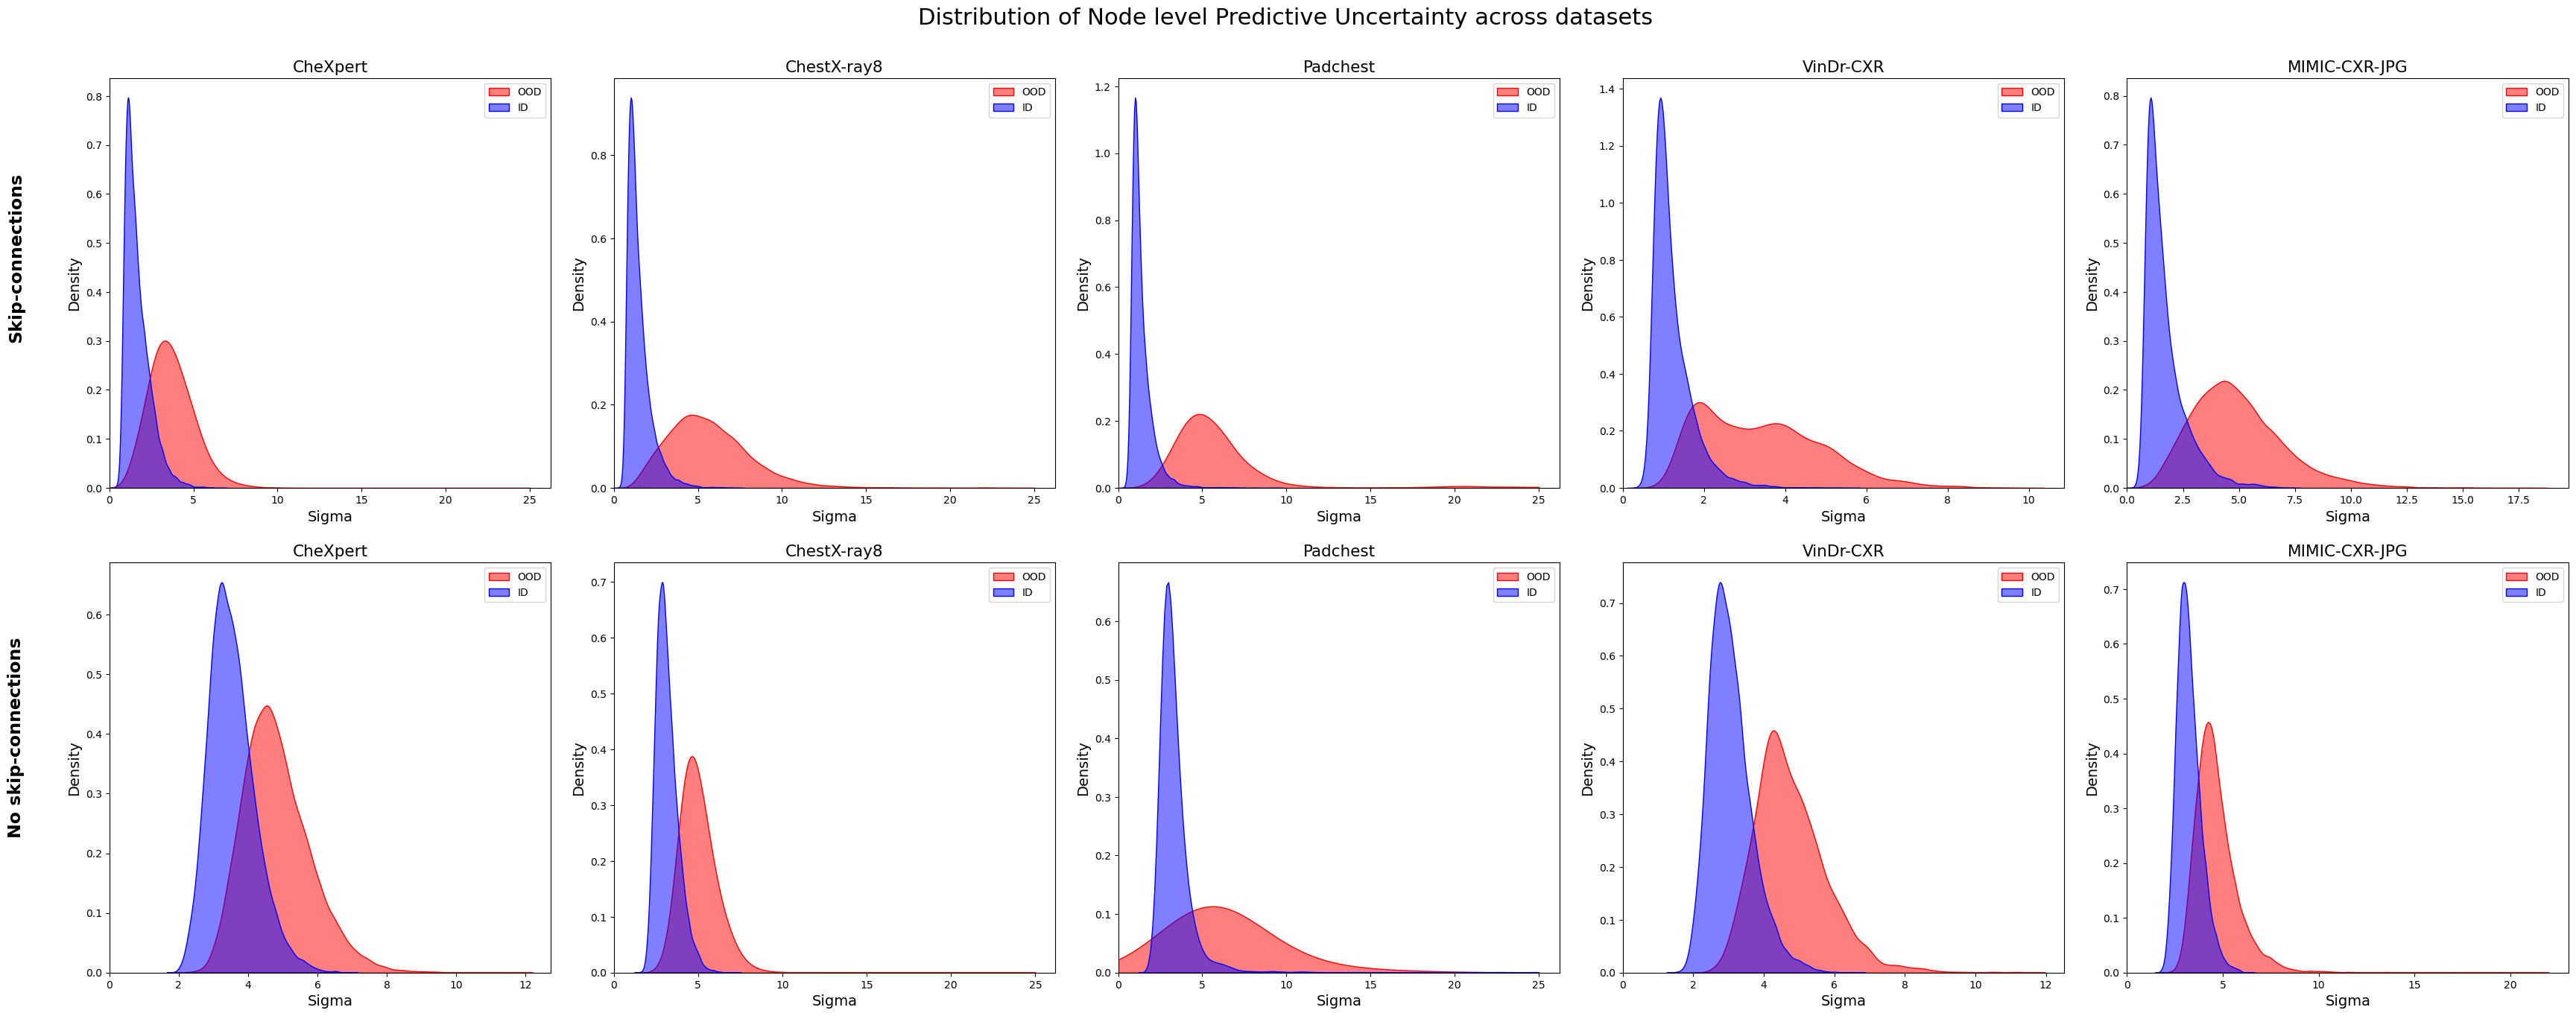

In [15]:
fig, axes = plot_kde_comparison_grid(
    id_skip=sigmas_id_skip,
    ood_skip=sigmas_ood_skip,
    id_noskip=sigmas_id_noskip,
    ood_noskip=sigmas_ood_noskip,
    datasets=datasets,
    clip_skip=(0, 25),
    clip_noskip=(0, 25),
    suptitle="Distribution of Node level Predictive Uncertainty across datasets"
)


Best threshold (Skip): 2.457408
Best threshold (No Skip): 3.848371


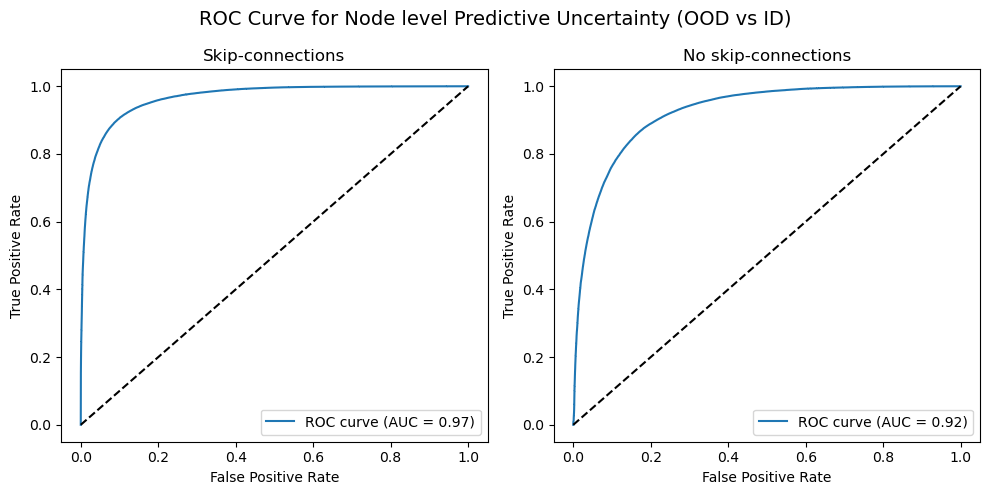

In [ ]:
fig, ax = plot_roc_curves(datasets, sigmas_id_skip, sigmas_ood_skip, sigmas_id_noskip, sigmas_ood_noskip,
                          'ROC Curve for Node level Predictive Uncertainty (OOD vs ID)')

#### Espacio latente

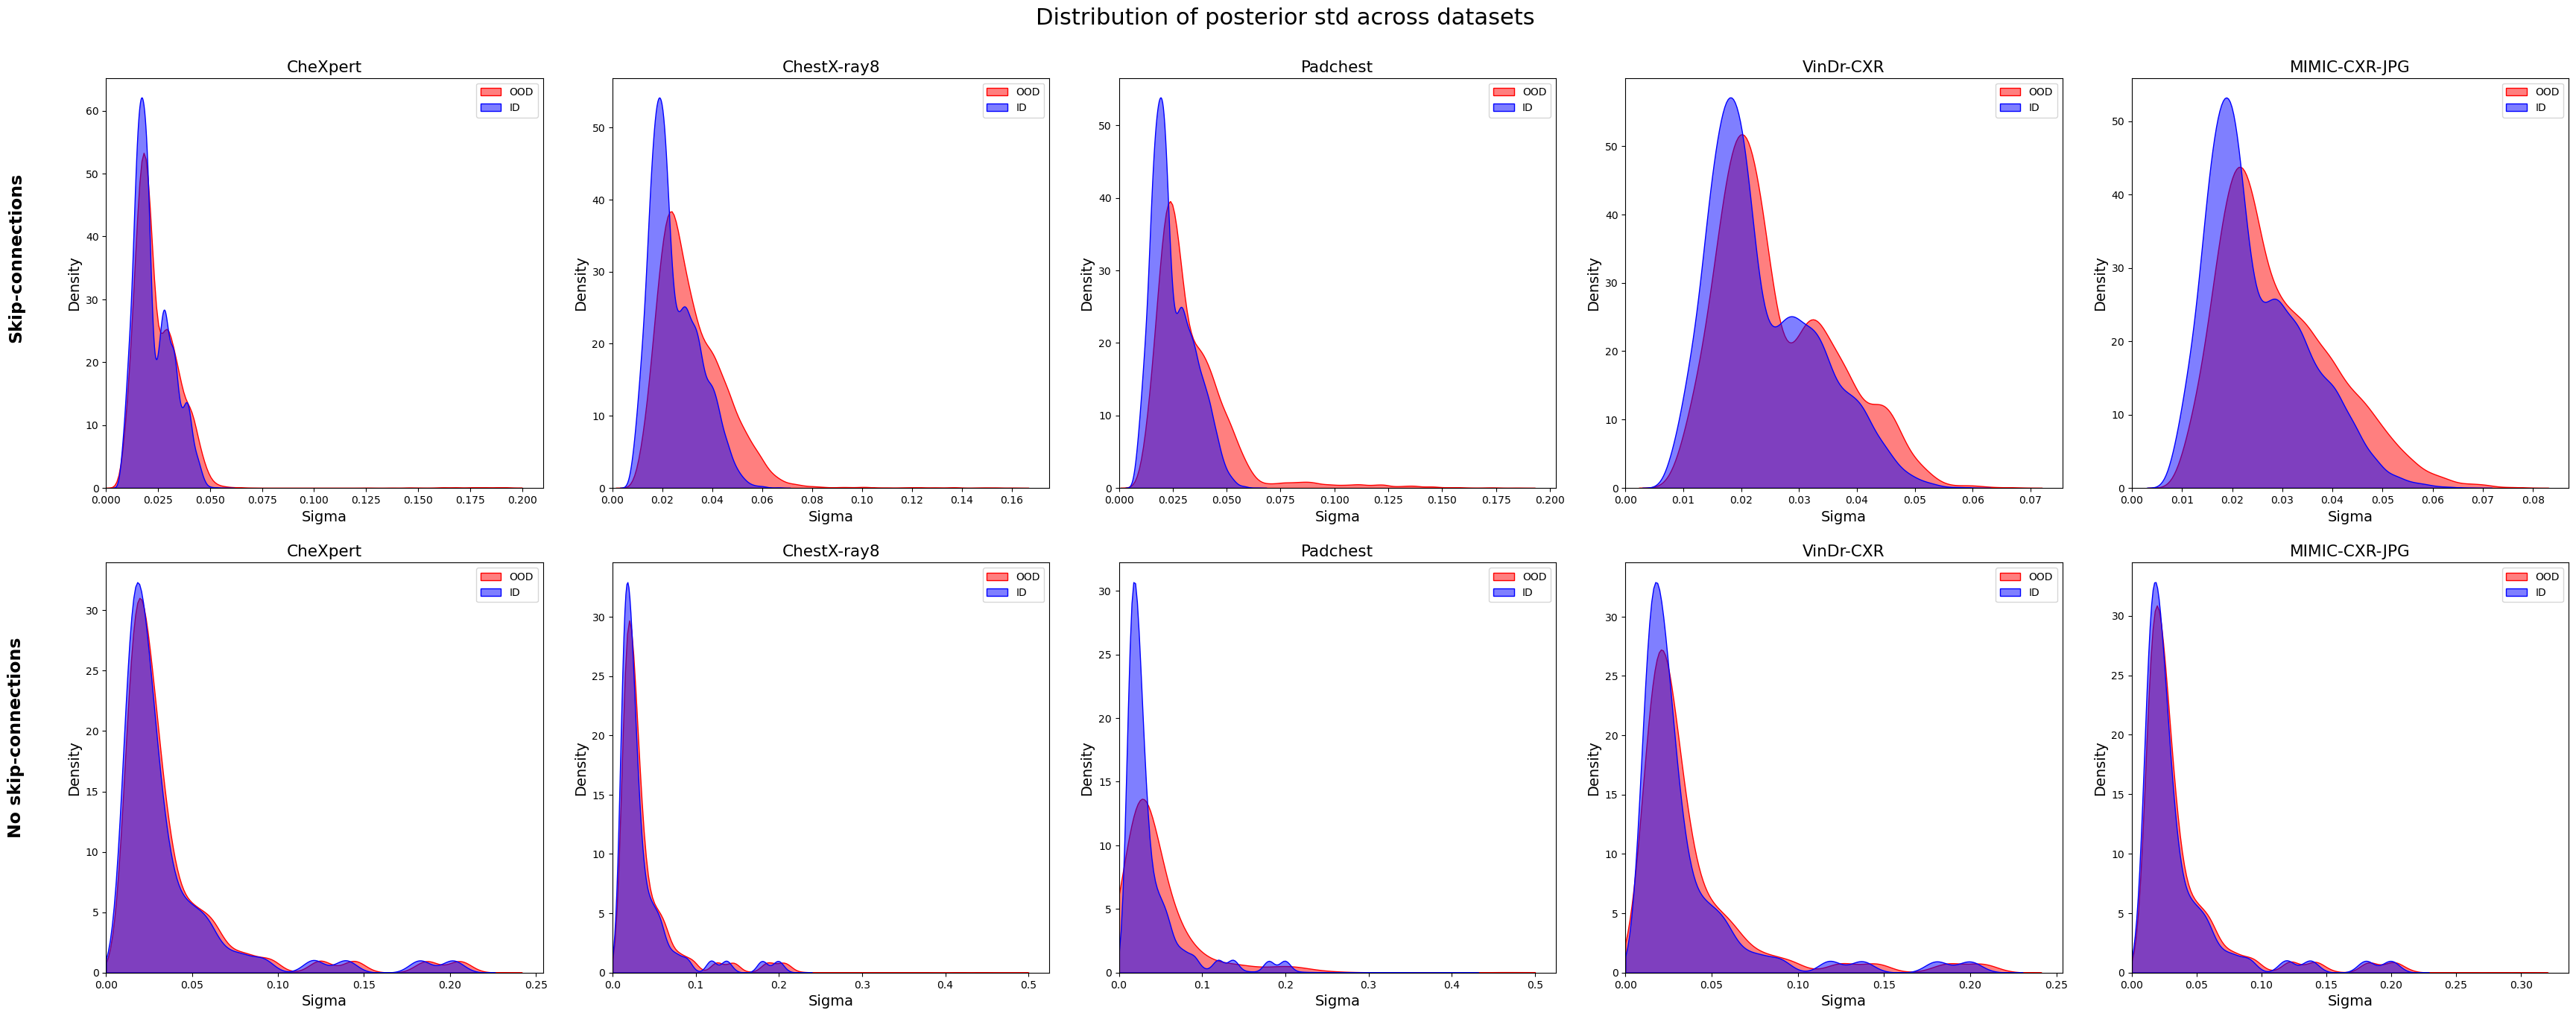

In [36]:
def flatten_scores(dict):
    flat_dict = {}
    for k in dict.keys():
        flat_dict[k] = dict[k].flatten()
    return flat_dict

fig, ax = plot_kde_comparison_grid(
    datasets=datasets,
    id_skip=flatten_scores(latents_id_skip),
    ood_skip=flatten_scores(latents_ood_skip),
    id_noskip=flatten_scores(latents_id_noskip),
    ood_noskip=flatten_scores(latents_ood_noskip),
    clip_skip=(0, 0.2),
    clip_noskip=(0, 0.5),
    suptitle="Distribution of posterior std across datasets"
)

In [17]:
def evaluate_oneclass_svm(latents_id, latents_ood, datasets, param_grid, test_size=0.3):
    id = np.concatenate([latents_id[ds] for ds in datasets], axis=0)
    ood = np.concatenate([latents_ood[ds] for ds in datasets], axis=0)

    # Split ID and OOD
    id_train, id_test = train_test_split(id, test_size=test_size, random_state=42)
    _, ood_test = train_test_split(ood, test_size=test_size, random_state=42)  # ignore ood_train

    X_test = np.concatenate([id_test, ood_test])
    y_test = np.concatenate([np.zeros(len(id_test)), np.ones(len(ood_test))])
    
    # Scale features
    scaler = StandardScaler()
    id_train_scaled = scaler.fit_transform(id_train)
    X_test_scaled = scaler.transform(X_test)

    results = []

    # Iterate over parameter grid
    for params in list(ParameterGrid(param_grid)):
        model = OneClassSVM(**params)
        model.fit(id_train_scaled)

        decision_scores = model.decision_function(X_test_scaled)
        anomaly_scores = -decision_scores

        fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
        roc_auc = auc(fpr, tpr)

        result = {'AUC': roc_auc, **params}
        results.append(result)

    return pd.DataFrame(results).sort_values(by='AUC', ascending=False)

In [20]:
param_grid = {
    'kernel': ['rbf', 'linear'],
    'nu': [0.05, 0.1, 0.2, 0.3, 0.5]
}

results_skip = evaluate_oneclass_svm(latents_id_skip, latents_ood_skip, datasets, param_grid)
results_noskip = evaluate_oneclass_svm(latents_id_noskip, latents_ood_noskip, datasets, param_grid)

results_noskip

,AUC,kernel,nu
8,0.942953,linear,0.30
7,0.925079,linear,0.20
9,0.909475,linear,0.50
1,0.863570,rbf,0.10
5,0.851247,linear,0.05
0,0.841010,rbf,0.05
6,0.815433,linear,0.10
4,0.812349,rbf,0.50
2,0.808228,rbf,0.20
3,0.798780,rbf,0.30
